# Modelling approach

The modelling approach here is to iterate over a list of classifiers and run a grid search 10 fold cross validation.

As pointed out in the exploration stage, there are a number of features which do not have a linear relationship with the target (`Age` and `LastContactMonth`) so the tree based methods are expected to be the best performers.


In [1]:
# Reload local modules as they are changing a lot
%load_ext autoreload
%autoreload 2
import warnings

# Deprecations and pandas slice warnings due to the train_test split
warnings.filterwarnings('ignore')

Load in data from the `DATA_DIR` and start with features (X) and target (y): 

In [2]:
from trainer_lib import DataManager
from trainer_lib.utils.notebook_config import DATA_DIR, REPORT_DIR
print(f"Data directory: {DATA_DIR}")
print(f"Report directory: {REPORT_DIR}")
# The instantiation will fetch the data and documentation
mngr = DataManager(save_path=DATA_DIR, report_path=REPORT_DIR)
X,y = mngr.train
X_test, _ = mngr.train


Data directory: ../data/raw/
Report directory: ../reports/


In [8]:
from trainer_lib.modelling.train import Trainer, Evaluation, Explain
from trainer_lib.utils.notebook_config import MODEL_DIR
from trainer_lib.modelling.model_config import GRID_SEARCH, MODEL_POST_URL

In [9]:
trainer = Trainer(X,y, GRID_SEARCH, MODEL_DIR, MODEL_POST_URL)
trainer.train("Test")

Output()

**The following code will only work for XGBOOST as the classifier**

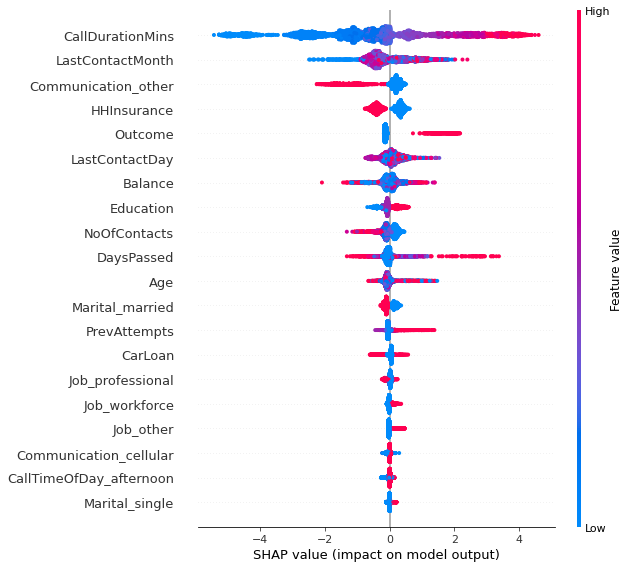

NameError: name 'hasher' is not defined

In [10]:
import matplotlib.pyplot as plt
import shap
explain = Explain(trainer.best_classifier, X)
explain.summary()

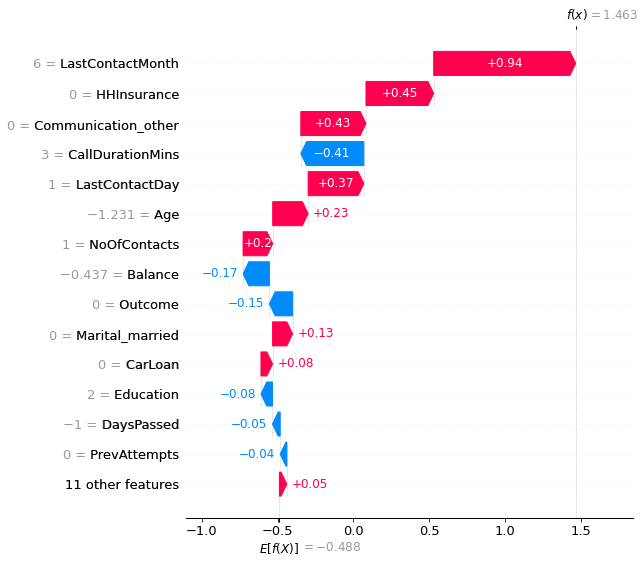

In [63]:
explain.waterfall(10)

In [71]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()
explain.prediction(10)

In [7]:
trainer.best_classifier.named_steps['pre_processing'].named_steps

{'feature_engineering': Pipeline(steps=[('add_time_duration', CallDurationTransformer()),
                 ('add_time_of_day', TimeOfDayTransformer()),
                 ('convert_job', JobTransformer()),
                 ('convert_month', MonthNameTransformer()),
                 ('convert_education', EducationTransformer()),
                 ('convert_outcome', OutcomeTransformer()),
                 ('impute_missing',
                  DatasetCleanerPipeline(config={'Communication': {'strategy': 'const...'strategy': 'median'}, 'Outcome': {'strategy': 'constant', 'fill_value': 0}})),
                 ('column_selection',
                  SelectFeaturesTransfomer(features=['Job', 'Marital',
                                                     'Communication',
                                                     'CallTimeOfDay', 'Age',
                                                     'Balance', 'LastContactDay',
                                                     'LastContactMonth